Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL410250 / EEL7513 / EEL7514 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bG}{\mathbf{G}}$
$\newcommand{\bg}{\mathbf{g}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bC}{\mathbf{C}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 10: Detecção de Anomalias e Sistemas de Recomendação

Neste exercício, você irá investigar o problema de detecção de anomalias (modelado como aprendizado não-supervisionado ou semi-supervisionado) usando modelos gaussianos e redes neurais autoencoders. Além disso, você irá investigar a técnica de filtragem colaborativa para sistemas de recomendação.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

def gen_data(clean=True):
    from sklearn.datasets import make_blobs
    from sklearn.utils import shuffle
    rot = lambda a: np.array([[np.cos(a), np.sin(a)], [np.sin(-a), np.cos(a)]])
    m0, m1 = (300, 10)
    X0 = make_blobs(n_samples=2*m0, n_features=2, centers=[[0, 0]], cluster_std=0.8, random_state=0)[0]
    X1 = make_blobs(n_samples=2*m1, n_features=2, centers=[[0, 0]], cluster_std=4, random_state=3)[0]
    X0 = [15, 15] + X0 @ np.diag((2.5,1)) @ rot(np.pi*60/180)
    X1 = [15, 15] + X1 @ np.diag((2.5,1)) @ rot(-np.pi*60/180)
    X1 = shuffle(X1, random_state=3)
    X = np.r_[X0[:m0], X1[:m1], X0[m0:], X1[m1:]]
    X_train = shuffle(X[:m0 if clean else m0+m1], random_state=0)
    X_val, y_val = shuffle(X[m0+m1:], np.r_[np.zeros(m0), np.ones(m1)], random_state=1)
    return X_train, X_val, y_val

def plot_data(X, y_true=None, y_pred=None, *, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    # mark anomalies
    if y_true is not None:
        y_true = y_true > 0
        plt.scatter(X[y_true,0], X[y_true,1], c='red', marker='x', s=50)
    # mark predictions
    if y_pred is not None:
        y_pred = y_pred > 0
        plt.scatter(X[y_pred,0], X[y_pred,1], c='none', marker='o', edgecolors='black', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 16), cmap=plt.cm.Greens_r, zorder=-1)
    return

def max_f1_score(y_true, y_score):
    # slow implementation; don't use for large datasets
    ts = np.unique(y_score)
    ts = (np.r_[2*ts[0]-ts[1], ts] + np.r_[ts, 2*ts[-1]-ts[-2]])/2
    f1s = np.zeros(len(ts))
    best = 0
    for i, t in enumerate(ts):
        y_pred = y_score > t
        f1s[i] = f1_score(y_true, y_pred)
        if f1s[i] > f1s[best]:
            best = i
    return f1s[best], ts[best]

# Detecção de anomalias

## 1. Conjunto de dados #1

Neste parte do exercício, nosso objetivo é construir um modelo gaussiano para detecção de anomalias. Começaremos utilizando um conjunto de dados sintético para aprendizado semi-supervisionado, também conhecido como detecção de novidades, em que o conjunto de treinamento é composto somente por amostras normais. Você dispõe de um conjunto de validação rotulado, onde o rótulo 1 indica uma anomalia e o rótulo 0 indica um amostra normal.

Train shape: (300, 2)
 Val shapes: (310, 2) (310,)


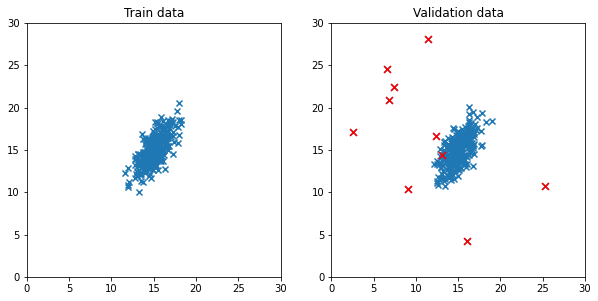

In [2]:
X_train, X_val, y_val = gen_data(clean=True)
print('Train shape:', X_train.shape)
print(' Val shapes:', X_val.shape, y_val.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Train data')
plot_data(X_train)
plt.subplot(1,2,2)
plt.title('Validation data')
plot_data(X_val, y_val)

### Construindo um modelo gaussiano

1. Utilize um modelo gaussiano multivariável para ajustar o conjunto de treinamento, i.e., estime a média e a matriz de covariância dos dados. Para isso, utilize as funções `np.mean` e `np.cov` (configure corretamente os parâmetros `axis` e `rowvar`). Trace curvas de nível da densidade de probabilidade usando a função `plot_data(X_train, mean=mean, cov=cov)`. 
2. Para fins de comparação, realize também uma estimação da matriz de covariância sob a hipótese de independência, i.e., estime a variância de cada dimensão independentemente e utilize esses valores para produzir uma matriz de covariância diagonal. Para isso, utilize a função `np.var` (configure corretamente o parâmetro `axis`). Visualize as curvas de nível usando a função `plot_data(X_train, mean=mean, cov=var)`.
3. Qual estimação parece mais adequada? Por quê?

#### Dica
- Se quiser obter `np.diag(cov)` igual a `var`, certifique-se de utilizar nos dois o mesmo valor do parâmetro `ddof`, seja uma estimativa [enviesada ou não](https://en.wikipedia.org/wiki/Variance#Sample_variance).

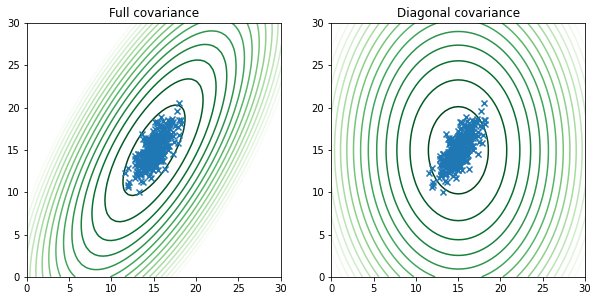

Em um modelo gaussiano, a densidade de probabilidade de uma amostra $\bx$ é calculada como

$$p(\bx) = \frac{1}{\sqrt{\det(2\pi\bC)}} \exp\left(-\frac{1}{2}(\bx-\bmu)^T \bC^{-1} (\bx-\bmu)\right)$$

onde $\bmu$ é o vetor de médias e $\bC$ é a matriz de covariância (`mean` e `cov` estimados previamente).

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ seja classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar: trata-se de uma escolha arbitrária que depende do nível de precisão (*precision*) ou revocação (*recall*) desejado. Mesmo para um nível de precisão ou revocação escolhido, o valor específico de $\epsilon$ vai depender do modelo probabilístico utilizado. Uma abordagem comumente utilizada é escolher o limiar que maximiza o [score F1](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure), a média harmônica entre precisão e revocação. Note que, para calcular quaisquer dessas métricas, é necessário dispor de um conjunto de validação rotulado.

4. Escolha alguns valores de $\epsilon$ e realize a predição no conjunto de validação. Para isso, utilize a função `scipy.stats.multivariate_normal(mean, cov)` para definir o modelo e o respectivo método `.pdf` para calcular a densidade de probabilidade. Para cada valor de $\epsilon$, marque as anomalias encontradas no gráfico (círculos pretos) usando a função `plot_data(X_val, y_val, y_pred, mean=mean, cov=cov)` e calcule também o score F1.

#### Dicas

- As curvas de nível da função `plot_data` correspondem a $p = 10^{-3}, 10^{-6}, 10^{-9}, \ldots$
- Você pode utilizar a função `sklearn.metrics.f1_score` para calcular o score F1.
- É possível atingir F1 > 90%.

### Usando o scikit-learn

Ao invés de usar as funções acima, é mais conveniente usar o objeto `sklearn.covariance.EmpiricalCovariance`, que implementa estimação e inferência de forma integrada. No entanto, não há uma função para cálculo de probabilidade: está implementado apenas o cálculo da [distância de Mahalanobis](https://en.wikipedia.org/wiki/Mahalanobis_distance) ao quadrado (função `.mahalanobis`), correspondente ao termo

$$d^2 = (\bx-\bmu)^T \bC^{-1} (\bx-\bmu)$$

de tal forma que

$$p(\bx) = \frac{1}{\sqrt{\det(2\pi\bC)}} \exp(-d^2/2).$$

Note, porém, que $p(\bx) < \epsilon \iff d^2 > \gamma \triangleq -2\log\left(\epsilon \sqrt{\det(2\pi\bC)}\right)$. Portanto, é matematicamente equivalente realizar a detecção de anomalias através da distância (quadrada) de Mahalanobis, sendo que quanto *maior* esse valor, *maior* a chance de a amostra ser anômala.

5. Treine o estimador `EmpiricalCovariance` no conjunto de treinamento e confirme que obtém os mesmos valores de média e covariância obtidos anteriormente. Calcule também a distância (quadrada) de Mahalanobis das 3 primeiras amostras do conjunto de treinamento e suas respectivas probabilidades (conforme equação acima) e confirme que são as mesmas que os valores calculados pelo modelo `multivariate_normal` do item anterior.
1. Repita o item 4 para alguns valores de limiar ($\gamma$) com o estimador `EmpiricalCovariance`.
1. Utilize a função fornecida `max_f1_score(y_true, y_score)` para determinar o máximo valor de F1 alcançável no conjunto de validação, onde `y_score` representa um score de confiança de que a amostra é positiva; neste caso, pode ser usado o valor de $d^2$. A função retorna o valor de F1 e o respectivo limiar utilizado para alcançar esse valor.

#### Dicas
- Os parâmetros estimados pelo modelo ficam armazenados em `.location_` e `.covariance_` (veja documentação).
- Utilize `np.linalg.det` para cálculo de determinante.

## 2. Conjunto de dados #2

O próximo conjunto de dados é idêntico ao anterior, exceto pelo fato de que o conjunto de treinamento agora é **não-rotulado**, podendo conter amostras anômalas -- o que também é conhecido como um conjunto "contaminado". Dessa forma, o problema se enquadrada como aprendizado não-supervisionado. Em particular, o conjunto de treinamento possui claros outliers, os quais podem afetar o comportamento do modelo, como veremos a seguir.

Train shape: (310, 2)
 Val shapes: (310, 2) (310,)


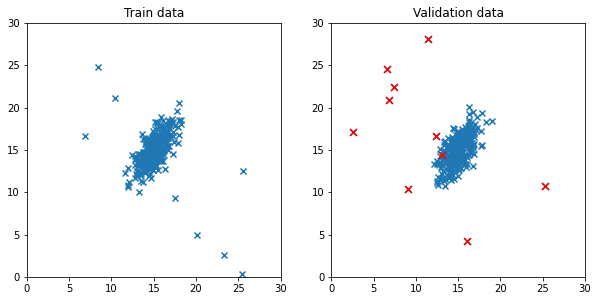

In [4]:
X_train, X_val, y_val = gen_data(clean=False)
print('Train shape:', X_train.shape)
print(' Val shapes:', X_val.shape, y_val.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Train data')
plot_data(X_train)
plt.subplot(1,2,2)
plt.title('Validation data')
plot_data(X_val, y_val)

1. Treine o estimador `EmpiricalCovariance` no conjunto de treinamento e mostre o resultado usando a função `plot_data(X_train, mean=mean, cov=cov)`. Compare com o resultado obtido no item 1.1 (ou 1.5). Como você explica a diferença?
1. Escolha alguns valores de limiar e, para cada um deles, realize a predição no conjunto de validação, marque as anomalias encontradas no gráfico usando a função `plot_data(X_val, y_val, y_pred, mean=mean, cov=cov)` e calcule também o score F1.
1. Determine o máximo valor de F1 alcançável no conjunto de validação e respectivo limiar.

4. Agora, repita os três itens anteriores usando o algoritmo `sklearn.covariance.MinCovDet` e compare os resultados obtidos. Foi possível alcançar o mesmo valor de F1 obtido no conjunto de dados "limpo" (item 1.7)?

#### Observações (para saber mais)
- O algoritmo `MinCovDet` assume o mesmo modelo gaussiano, porém com uma estimação de covariância robusta a outliers, devido principalmente aos seguintes aspectos:
 - O algoritmo utiliza apenas uma fração `support_fraction` das amostras na estimação inicial da matriz de covariância;
 - A estimação final é feita reponderando as amostras de acordo com sua distância de Mahalanobis, de forma que amostras mais distantes tenham menor impacto na estimação.
- Mesmo em um problema de detecção de novidades (conjunto de treinamento formado só por amostras normais), o algoritmo `MinCovDet` pode apresentar um desempenho superior ao do `EmpiricalCovariance`, devido à sua etapa de reponderação de amostras, caso o conjunto de treinamento possua outliers (nem todo outlier é necessariamente uma anomalia e nem toda anomalia é necessariamente um outlier, para um dado conjunto de atributos). Nesse caso, pode ser útil aumentar o parâmetro `support_fraction` para acelerar o algoritmo.
- Caso não disponha de um conjunto de validação, mas conheça a proporção de amostras "contaminadas" no conjunto de treinamento, você pode ainda utilizar o algoritmo `sklearn.covariance.EllipticEnvelope`, o qual internamente utiliza o `MinCovDet`, mas define o limiar de classificação automaticamente de tal forma a obter uma determinada fração de outliers no conjunto de treinamento, dada pelo parâmetro `contamination`. Note que a função `.predict` deste modelo utiliza a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal.

## 3. Conjunto de dados #3

O próximo conjunto consiste de dados de transações de cartão de crédito, disponível em:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O objetivo é identificar transações fradulentas. O conjunto é formado por 284807 amostras, sendo destas 492 fradulentas. Os atributos consistem do rótulo da transação ($y=1$ corresponde a uma transação fradulenta) e 30 atributos de entrada, sendo que destes 28 correspondem às componentes principais dos atributos originais, os quais não são fornecidos por uma questão de confidencialidade. (Incidentalmente, este conjunto ilustra mais uma aplicação de PCA: anonimização.)

Separe 2/3 das amostras normais como conjunto de treinamento e, como conjunto de validação, utilize todas as amostras anômalas e as restantes 1/3 de amostras normais. Para avaliação de desempenho do classificador, utilize a métrica [*average precision*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) (`sklearn.metrics.average_precision_score`) sobre o conjunto de validação, a qual pode ser interpretada como a área embaixo da curva *precision-recall*.

1. Primeiramente, separe o conjunto de dados e realize uma análise exploratória do conjunto de treinamento. Em particular, trace o histograma de cada atributo e avalie se é interessante aplicar alguma transformação.
1. Treine um modelo gaussiano e avalie seu desempenho. 
1. Trace a curva *precision-recall* (utilize `sklearn.metrics.precision_recall_curve`) e determine um valor de limiar correspondendo ao "joelho" da curva. Para este limiar, obtenha os valores correspondentes de *precision* e *recall*.
1. (OPCIONAL) Desenvolva um modelo de rede neural autoencoder (usando Keras) e tente obter um desempenho próximo (ou superior) ao modelo gaussiano. Lembre que o objetivo do autoencoder é reconstruir o vetor de entrada, portanto trata-se de um problema de regressão em que $\by = \bx$. Para que o autoencoder possa ser uma boa solução para este problema, é preciso que o erro de reconstrução sobre as amostras anômalas seja significativamente maior que o erro sobre as amostras normais.

### Dicas
- Se estiver usando o Google Colab, é desnecessário baixar o conjunto de dados para o seu PC e depois fazer o upload para o Colab; é muito mais rápido transferir diretamente do Kaggle para o Colab. Para isso, primeiro autentique-se conforme indicado em [How to use the Kaggle API from Colab](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb). Em seguida, baixe o conjunto de dados diretamente no Colab digitando:

```python
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download "mlg-ulb/creditcardfraud"
!unzip creditcardfraud.zip
```
- A métrica *average precision* sumariza o desempenho do classificador sobre todos os possíveis limiares, portanto não há necessidade de escolher um limiar; ao invés disso devem ser entregues à função scores de confiança de que a amostra é positiva, como por exemplo a distância de Mahalanobis no caso de um modelo gaussiano ou a saída não-binarizada no caso de um classificador binário convencional.
- Experimente normalizar os dados.
- Pode ser útil (ou não) excluir atributos.
- É possível atingir AP > 70% com um modelo gaussiano.

In [5]:
import pandas as pd
# Download data from Kaggle
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Sistemas de recomendação

Nesta parte do exercício iremos utilizar o Keras para implementar um sistema de recomendação. Um exemplo é mostrado abaixo (conjunto de dados retirado dos slides).

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Flatten, Dot
from tensorflow.keras.optimizers import Adam

n_users = 4
n_items = 5

title = {0: 'Star Wars',
         1: 'Matrix',
         2: 'X-Men',
         3: 'Titanic',
         4: 'Casablanca'}

# [user, item, rating]
data = np.array([[0,0,0],
                 [0,1,0],
                 [0,3,4],
                 [1,0,5],
                 [1,1,5],
                 [1,3,0],
                 [1,4,0],
                 [2,0,5],
                 [2,2,4],
                 [2,3,0],
                 [2,4,0],
                 [3,0,0],
                 [3,2,0],
                 [3,3,5],
                 [3,4,5]])

x = data[:,[0,1]]
y = data[:,2]

n_factors = 2

def get_model():
    x = Input(shape=(2,), dtype='int64')
    z1 = Embedding(n_users, n_factors, name='user_embedding')(x[:,0])
    z1 = Flatten()(z1)
    z2 = Embedding(n_items, n_factors, name='item_embedding')(x[:,1])
    z2 = Flatten()(z2)
    y = Dot(axes=1)([z1, z2])
    model = Model(inputs=x, outputs=y)
    return model

get_model().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 2)            8           tf_op_layer_strided_slice[0][0]  
_______________________________________________________________________________________

In [15]:
model = get_model()
model.compile(loss='mse', optimizer=Adam(lr=0.1))
history = model.fit(x, y, epochs=80)

Epoch 1/80
1/1 [==============================] - 0s 1ms/step - loss: 10.4685
Epoch 2/80
1/1 [==============================] - 0s 999us/step - loss: 10.4191
Epoch 3/80
1/1 [==============================] - 0s 2ms/step - loss: 10.2752
Epoch 4/80
1/1 [==============================] - 0s 2ms/step - loss: 10.0568
Epoch 5/80
1/1 [==============================] - 0s 997us/step - loss: 9.7524
Epoch 6/80
1/1 [==============================] - 0s 999us/step - loss: 9.3477
Epoch 7/80
1/1 [==============================] - 0s 2ms/step - loss: 8.8491
Epoch 8/80
1/1 [==============================] - 0s 997us/step - loss: 8.2725
Epoch 9/80
1/1 [==============================] - 0s 998us/step - loss: 7.6383
Epoch 10/80
1/1 [==============================] - 0s 997us/step - loss: 6.9735
Epoch 11/80
1/1 [==============================] - 0s 2ms/step - loss: 6.3079
Epoch 12/80
1/1 [==============================] - 0s 997us/step - loss: 5.6675
Epoch 13/80
1/1 [==============================] - 0s 9

In [16]:
for i in [2, 4]:
    print("Alice's predicted rating for {}:".format(title[i]), model.predict(np.array([[0,i]])).squeeze())

Alice's predicted rating for X-Men: 0.03295827
Alice's predicted rating for Casablanca: 4.056787


In [17]:
# matrix of item embeddings
Q = model.get_layer('item_embedding').weights[0].numpy()

In [18]:
from sklearn.neighbors import NearestNeighbors

i = 3
K = 2
nbrs = NearestNeighbors(n_neighbors=K).fit(Q)
_, indices = nbrs.kneighbors(Q[[i]])
print('The {} most similar to {} (including itself) are:'.format(K, title[i]))
for j in indices[0]:
    print(title[j])

The 2 most similar to Titanic (including itself) are:
Titanic
Casablanca


In [19]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=2)
cluster.fit(Q)
for k in range(cluster.n_clusters):
    print('Cluster {}:'.format(k))
    for i in np.where(cluster.labels_ == k)[0]:
        print(title[i])
    print()

Cluster 0:
Titanic
Casablanca

Cluster 1:
Star Wars
Matrix
X-Men



## 4. Conjunto de dados #4

1. Baseado no exemplo acima, desenvolva um modelo de predição para o conjunto de dados [MovieLens Latest Small](https://grouplens.org/datasets/movielens), o qual consiste de 100836 avaliações de 9742 filmes feitas por 610 usuários entre março de 1996 e setembro de 2018 (leia mais na [documentação](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)). Certifique-se de separar o conjunto em 90% de treinamento e 10% de validação e meça o MSE de validação.

2. (OPCIONAL) Para melhorar o desempenho do modelo, introduza *biases* de usuários e de filmes, bem como um *bias* geral. Outra técnica que ajuda é restringir os valores da saída através de uma função sigmóide, naturalmente escalonada para a faixa de interesse. Veja se consegue alcançar um MSE de validação de aproximadamente 0.74.

3. (OPCIONAL) Explore o modelo obtido: forneça as 10 melhores recomendações para algum usuário, encontre filmes similares a um dado filme e encontre clusters de filmes semelhantes.

#### Dicas
- Será necessário aplicar um codificador como o `sklearn.preprocessing.OrdinalEncoder(dtype=int)` para converter o conjunto de usuários e o conjunto de itens em inteiros consecutivos a partir de zero, pois isso é assumido pela camada de Embedding do Keras (em particular, os índices dos filmes não são consecutivos).
- As seguintes camadas do Keras podem ser úteis: `Add` e `Lambda`.

In [20]:
from zipfile import ZipFile
from tensorflow.keras.utils import get_file
filename = 'ml-latest-small.zip'
url = 'http://files.grouplens.org/datasets/movielens/' + filename
with ZipFile(get_file(filename, url)) as z:
    movies = pd.read_csv(z.open('ml-latest-small/movies.csv'), index_col=0)
    data = pd.read_csv(z.open('ml-latest-small/ratings.csv'), usecols=[0,1,2])

In [21]:
def search(query):
    return movies[movies.title.str.contains(query, case=False)]

In [22]:
# from title to movieId
search('matrix')

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6934,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
27660,"Animatrix, The (2003)",Action|Animation|Drama|Sci-Fi


In [23]:
# from movieId to title
movies.title[2571]

'Matrix, The (1999)'

In [24]:
# ratings
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
